In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Definition of basic functions

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    """
    Saves a GIF file from a set image files
    """
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)



def exact_solution(gamma, y0, x):
    """
    Exact solution for the exponential decay equation.
    """
    exp = torch.exp(-gamma*x)
    y  = y0*exp
    return y


class DNN(nn.Module):
    """
    Defines a dense connected network
    ============================================================================
    N_INPUT: number of input variables
    N_OUTPUT: number of output variables
    N_HIDDEN: number of units per hidden layer
    N_LAYERS: number of hidden layers
    ============================================================================
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # The tanh activation restricts output to [-1, 1] 
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Training the Deep Neural Network using only data from the known solution.

Analytical solution size:  torch.Size([500, 1]) torch.Size([500, 1])
Training points:  torch.Size([10, 1]) torch.Size([10, 1])


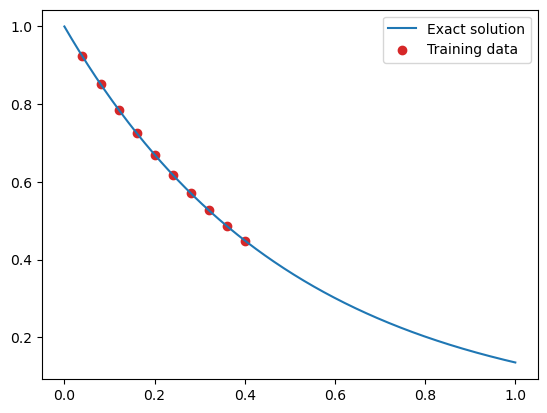

In [3]:
# Parameters of the differential equation
gamma = 2.

# Initial condition
x0 = 0.
y0 = 1.

# Domain of integration
x = torch.linspace(x0,1,500).view(-1,1)

# Analytical solution over the full domain
y = exact_solution(gamma, y0, x).view(-1,1)
print('Analytical solution size: ', x.shape, y.shape)

# Initial condition in tensor form
x0 = torch.tensor(x0).view(-1,1)
y0 = torch.tensor(y0).view(-1,1)

# slice out a small number of points (10) from the domain
x_data = x[20:220:20]
y_data = y[20:220:20]
print('Training points: ',x_data.shape, y_data.shape)


# Plot of the exact solution
plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:red", label="Training data")
plt.legend()
plt.show()

Epoch:  100  Loss:  0.002440566662698984
Epoch:  200  Loss:  0.0003196538600604981
Epoch:  300  Loss:  0.0003021956072188914
Epoch:  400  Loss:  0.0002816493215505034
Epoch:  500  Loss:  0.0002584114554338157
Epoch:  600  Loss:  0.00023278885055333376
Epoch:  700  Loss:  0.00020507784211076796
Epoch:  800  Loss:  0.00017569487681612372
Epoch:  900  Loss:  0.0001453065051464364
Epoch:  1000  Loss:  0.0001149376475950703


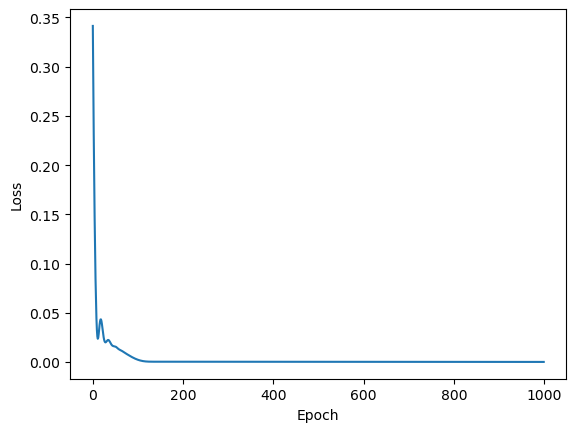

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x0, y0, s=60, color="tab:red", alpha=0.4, label='Initial Condition')
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


# Train the standard neural network to fit the training data

epochs = 1000

torch.manual_seed(413)
model = DNN(1,1,32,3) # 1 input, 1 output, 32 neurons in 3 hidden layers
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2) # mean squared error
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


    # Save plots of the training
    if (i+1) % 10 == 0:
        yh = model(x).detach()
        plot_result(x,y,x_data,y_data,yh)
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        plt.close()

        #if (i+1) % 500 == 0: plt.show()
        #else: plt.close("all")

    if (i+1) %100 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("nn.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Definition of the PINN and training using the differential equation, the initial condition and data from the known exact solution.

Epoch:  500  Loss:  0.009645331650972366
Epoch:  1000  Loss:  0.001119511085562408
Epoch:  1500  Loss:  0.0010917378822341561
Epoch:  2000  Loss:  0.0010635541984811425
Epoch:  2500  Loss:  0.0010260692797601223
Epoch:  3000  Loss:  0.0009769287426024675
Epoch:  3500  Loss:  0.0009128988604061306
Epoch:  4000  Loss:  0.0008294605067931116
Epoch:  4500  Loss:  0.0007207076414488256
Epoch:  5000  Loss:  0.0005806278204545379
Epoch:  5500  Loss:  0.0004094242467544973
Epoch:  6000  Loss:  0.00022822241589892656
Epoch:  6500  Loss:  8.621383312856779e-05
Epoch:  7000  Loss:  1.9455444999039173e-05
Epoch:  7500  Loss:  4.131814876018325e-06
Epoch:  8000  Loss:  2.5744054710230557e-06
Epoch:  8500  Loss:  2.4330590804311214e-06
Epoch:  9000  Loss:  2.339502771064872e-06
Epoch:  9500  Loss:  2.2411566078517353e-06
Epoch:  10000  Loss:  2.138975560228573e-06
Epoch:  10500  Loss:  2.0332108761067502e-06
Epoch:  11000  Loss:  1.922627461681259e-06
Epoch:  11500  Loss:  1.8263643823956954e-06
Epo

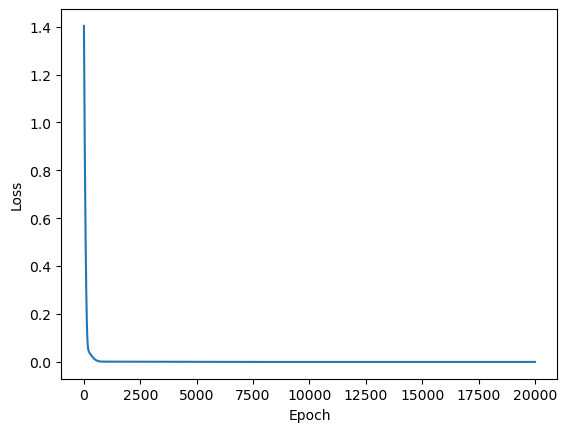

In [24]:
# Sample locations over the problem domain
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain

epochs =20000
torch.manual_seed(123)
model = DNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "initial condition loss"
    y0h = model(x0)
    loss1 = torch.mean((y0h-y0)**2)# use mean squared error

    # compute the "data loss"
    yh = model(x_data)
    loss2 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dydx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    physics = dydx + gamma*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss3 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2 + loss3 # add three loss terms together
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


    # plot the result as training progresses
    if (i+1) % 150 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("pinn1.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Definition of the PINN and training using the differential equation and the initial condition.

Epoch:  500  Loss:  7.562460086774081e-05
Epoch:  1000  Loss:  5.7813755120150745e-05
Epoch:  1500  Loss:  4.643669308279641e-05
Epoch:  2000  Loss:  3.938701775041409e-05
Epoch:  2500  Loss:  3.519082019920461e-05
Epoch:  3000  Loss:  3.25391702062916e-05
Epoch:  3500  Loss:  3.0443952709902078e-05
Epoch:  4000  Loss:  2.8378011847962625e-05
Epoch:  4500  Loss:  2.6163090296904556e-05
Epoch:  5000  Loss:  2.377829332544934e-05
Epoch:  5500  Loss:  2.1250451027299277e-05
Epoch:  6000  Loss:  1.8621845811139792e-05
Epoch:  6500  Loss:  1.5946043276926503e-05
Epoch:  7000  Loss:  1.3288956324686296e-05
Epoch:  7500  Loss:  1.072862960427301e-05
Epoch:  8000  Loss:  8.353570592589676e-06
Epoch:  8500  Loss:  6.2571907619712874e-06
Epoch:  9000  Loss:  4.526899829215836e-06
Epoch:  9500  Loss:  3.22227060678415e-06
Epoch:  10000  Loss:  2.3447662442777073e-06
Epoch:  10500  Loss:  1.8176128833147231e-06
Epoch:  11000  Loss:  1.506544776930241e-06
Epoch:  11500  Loss:  1.2851947985836887e-0

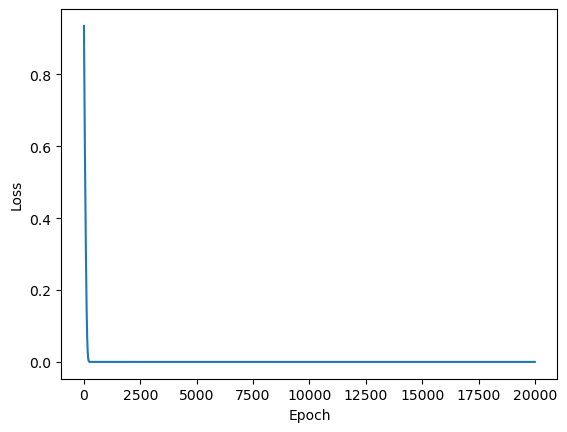

In [25]:
# Sample locations over the problem domain
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain

epochs =20000
torch.manual_seed(123)
model = DNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "initial condition loss"
    y0h = model(x0)
    loss1 = torch.mean((y0h-y0)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dydx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    physics = dydx + gamma*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss3 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss3 # add two loss terms together
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


    # plot the result as training progresses
    if (i+1) % 150 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()